# Chatbot Sederhana Menggunakan Seq2Seq LSTM
Tugas Akhir Semester

## 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


## 2. Load Dataset

In [2]:
df = pd.read_csv('oke_gas.csv')
df.drop_duplicates(inplace=True)
df = df[['pertanyaan', 'jawaban']].dropna()
df.head()


,pertanyaan,jawaban
0,"hai, hi","halo, ada yang bisa dibantu?"
1,"permisi, hi","halo, ada yang bisa dibantu?"
2,"selamat siang, hi","halo, ada yang bisa dibantu?"
3,"halo, hi","halo, ada yang bisa dibantu?"
4,hi,"halo, ada yang bisa dibantu?"


## 3. Preprocessing Teks

In [3]:
# 1. Preprocessing: bersihkan dan tambahkan <start> dan <end>
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9' ]", '', text)
    return text

df['pertanyaan'] = df['pertanyaan'].apply(clean_text)
df['jawaban'] = df['jawaban'].apply(lambda x: '<start> ' + clean_text(x) + ' <end>')

## 4. Tokenisasi dan Padding

In [4]:
input_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n') 
input_tokenizer.fit_on_texts(df['pertanyaan'])

target_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
target_tokenizer.fit_on_texts(df['jawaban'])

input_tensor = input_tokenizer.texts_to_sequences(df['pertanyaan'])
target_tensor = target_tokenizer.texts_to_sequences(df['jawaban'])

max_input_len = max(len(t) for t in input_tensor)
max_target_len = max(len(t) for t in target_tensor)

input_tensor = pad_sequences(input_tensor, maxlen=max_input_len, padding='post')
target_tensor = pad_sequences(target_tensor, maxlen=max_target_len, padding='post')

input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1


In [5]:
print('<start>' in target_tokenizer.word_index)
print(target_tokenizer.word_index.get('<start>', 'Tidak ditemukan'))

True
1


## 5. Split Dataset

In [6]:
from sklearn.model_selection import train_test_split
input_train, input_val, target_train, target_val = train_test_split(
    input_tensor, target_tensor, test_size=0.2, random_state=42)


## 6. Buat Model Seq2Seq

In [7]:
embedding_dim = 128
units = 256

# Encoder
encoder_inputs = Input(shape=(max_input_len,))
enc_emb = Embedding(input_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(units, return_state=True, dropout=0.4)(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_target_len - 1,))
dec_emb_layer = Embedding(target_vocab_size, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(target_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 20)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 114)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 20, 128)           │          56,576 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 114, 128)          │         139,136 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 256), (None,      │         394,240 │ embedding[0][0]            │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, 114, 256), (None, │         394,240 │ embedding_1[0][0],         │
│                               │ 256), (None, 256)]        │                 │ lstm[0][1], lstm[0][2]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 114, 1087)         │         279,359 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,263,551 (4.82 MB)

 Trainable params: 1,263,551 (4.82 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Training Model

In [8]:
target_train_in = target_train[:, :-1]
target_train_out = target_train[:, 1:]
target_val_in = target_val[:, :-1]
target_val_out = target_val[:, 1:]

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    [input_train, target_train_in],
    target_train_out[..., np.newaxis],
    validation_data=([input_val, target_val_in], target_val_out[..., np.newaxis]),
    batch_size=64,
    epochs=50,
    callbacks=[early_stop]
)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - loss: 3.8677 - val_loss: 1.4410
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 261ms/step - loss: 1.4561 - val_loss: 1.2682
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 261ms/step - loss: 1.2670 - val_loss: 1.1807
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - loss: 1.1618 - val_loss: 1.1445
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - loss: 1.1527 - val_loss: 1.1230
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - loss: 1.1467 - val_loss: 1.1098
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 245ms/step - loss: 1.1000 - val_loss: 1.0782
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - loss: 1.0917 - val_loss: 1.0494
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - loss: 1.0543 - val_loss: 1.0313
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - loss: 1.0383 - val_loss: 1.0007
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - loss: 1.0229 - val_loss: 0.9757
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/ste

## 8. Plot Loss

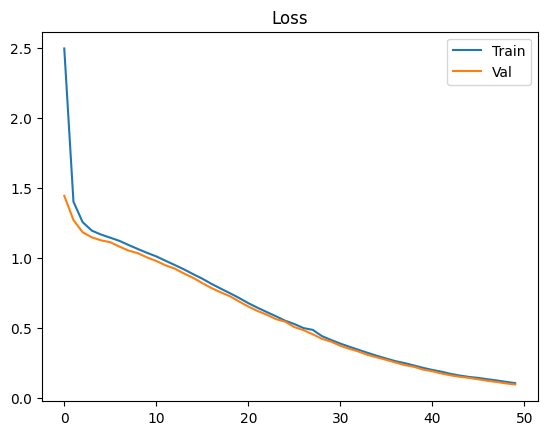

In [9]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.legend()
plt.title('Loss')
plt.show()


In [10]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(units,))
decoder_state_input_c = Input(shape=(units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

In [11]:
reverse_target_word_index = target_tokenizer.index_word
reverse_input_word_index = input_tokenizer.index_word
target_word_index = target_tokenizer.word_index

## 9. Fungsi Interaktif Chatbot

In [12]:
def decode_sequence(input_seq):
    # Ambil state encoder
    states_value = encoder_model.predict(input_seq)

    # Awal token: <start>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['<start>']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index.get(sampled_token_index, '')

        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_target_len:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Update target sequence dan state
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

In [13]:
def chatbot_response(input_text):
    input_seq = input_tokenizer.texts_to_sequences([clean_text(input_text)])
    input_seq = pad_sequences(input_seq, maxlen=max_input_len, padding='post')
    return decode_sequence(input_seq)

In [19]:
chatbot_response("selamat sore, Apa itu Disdukcapil Kota Pekanbaru?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

'disdukcapil kota pekanbaru menyediakan layanan pengurusan ktp elektronik pengurusan kartu keluarga akta kelahiran akta kematian akta pernikahan akta perceraian layanan pindah datang dan penerbitan skpwni surat keterangan pindah warga negara indonesia'

In [20]:
def chatbot_hybrid(input_text):
    cleaned = clean_text(input_text)
    if cleaned in df['pertanyaan'].values:
        return df[df['pertanyaan'] == cleaned]['jawaban'].values[0].replace('<start>', '').replace('<end>', '').strip()
    else:
        return chatbot_response(input_text)

In [22]:
def chatbot_loop():
    print("Chatbot siap! Ketik 'quit' untuk keluar.\n")
    while True:
        user_input = input("Kamu : ")
        if user_input.lower() == "quit":
            print("Chatbot: Sampai jumpa!")
            break
        response = chatbot_hybrid(user_input)  # Gunakan hybrid!
        print("Chatbot:", response, "\n")

In [23]:
chatbot_loop()

Chatbot siap! Ketik 'quit' untuk keluar.



Kamu :  hi


Chatbot: halo ada yang bisa dibantu 



Kamu :  halo


Chatbot: halo ada yang bisa dibantu 



Kamu :  selamat siang, Apakah dokumen persyaratan bisa diganti oleh dokumen lain?


Chatbot: jika belum punya ktpel boleh pakai surat keterangan pengganti atau surat pengantar dari disdukcapil 



Kamu :  quit


Chatbot: Sampai jumpa!


In [24]:
encoder_model.save('chatbot_encoder.h5')
decoder_model.save('chatbot_decoder.h5')

In [25]:
model.save('chatbot_seq2seq_full.h5')

In [26]:
import pickle

with open('input_tokenizer.pkl', 'wb') as f:
    pickle.dump(input_tokenizer, f)

with open('target_tokenizer.pkl', 'wb') as f:
    pickle.dump(target_tokenizer, f)